# TP n°1: HOG et SIFT - Comparaison
**Membres:**
- Guillaume Girouard 1954899
- Pierre-Emmanuel Rebours 2165286


# Sommaire :
1. [Méthode HOG](#methode-hog)
    1. [Implémentation des méthodes](#methode-hog-implementation)
    2. [Recherche d'hyperparamètre](#methode-hog-hyperparametre)
    3. [Résultat hypothèse 1 et 2](#methode-hog-hyp1-2)
    4. [Résultat hypothèse 3](#methode-hog-hyp3)
2. [Méthode SIFT](#methode-sift)
    1. [Implémentation des méthodes](#methode-sift-implementation)
    2. [Recherche d'hyperparamètre](#methode-sift-hyperparametre)
    3. [Résultat hypothèse 1](#methode-sift-hyp1)
    4. [Résultat hypothèse 2](#methode-sift-hyp2)
    5. [Résultat hypothèse 3](#methode-sift-hyp3)
3. [Temps d'exécution des méthodes](#temps-execution)

On commence par importer les librairies nécessaire à l'exécution de notre code

In [1]:
import cv2
import matplotlib.pyplot as plt
import scipy.spatial.distance as ssd
import numpy as np
from pathlib import Path
import os
from os import listdir

On initialise une liste et deux dictionnaires:
- img_labels contient l'ensemble des labels auquels sont rattachées les images
- img_query est un dictionnaire qui, à un label comme clé, associe le chemin qui mène à l'image requête correspondant à ce label
- img_data est un dictionnaire qui, à un label comme clé, associe les chemins qui mènent aux images du database correspondant à ce label

In [2]:
query_labels=["airplane","ball","car","cat","dolphin","face","lotus", "pickles","strawberry"]
img_labels=["airplane","ball","car","cat","dolphin","face","lotus", "pickles"]
withBoudingBox=False

In [3]:
pathToImages=""
if withBoudingBox:
    pathToImages="./data_boundingBox/"
else:
    pathToImages="./"
    
img_data={}
img_query={}
for label in query_labels:
    img_query[label] = [str(p) for p in Path(pathToImages).glob(label+'*')]
for label in img_labels:
    img_data[label] =  [str(p) for p in Path(pathToImages+"database").glob(label+'*')]
img_query

{'airplane': ['airplane_query.jpg'],
 'ball': ['ball_query.jpg'],
 'car': ['car_query.jpg'],
 'cat': ['cat_query.jpg'],
 'dolphin': ['dolphin_query.jpg'],
 'face': ['face_query.jpg'],
 'lotus': ['lotus_query.jpg'],
 'pickles': ['pickles_querry.jpg'],
 'strawberry': ['strawberry_query.jpg']}

### Méthode HOG <a class="anchor" id="methode-hog"></a>

#### Implémentation des méthodes <a class="anchor" id="methode-hog-implementation"></a>

On commence par implémenter les méthodes nécessaires à l'utilisation de la méthode HOG

Pour rendre nos descripteurs comparable d'une image à l'autre, il faut que ces derniers aient la même dimension. Pour cela nous avons choisi de mettre toutes les images à la même résolution: Pour cela nous avons simplement pris la résolution moyenne entre toute les images.

In [4]:
sizeX=0 
sizeY=0
nb_images=0
for label in img_labels:
    for path in img_data[label]:
        img = cv2.imread(path)
        sizeX+=img.shape[0]
        sizeY+=img.shape[1]
        nb_images+=1
sizeX=sizeX//nb_images #résolution moyenne selon l'axe horizontal
sizeY=sizeY//nb_images #résolution moyenne selon l'axe vertical
print("Résolution moyenne: "+str(sizeX)+"*"+str(sizeY))

Résolution moyenne: 629*572


On définit les fonctions pour récupérer les descripteurs HOG des images.

In [5]:
def getHOGDescriptor(img,hog):
    """
    Change la résolution de l'image img en sizeX*sizeY et renvoit le descripteur HOG associé à cette dernière.

    Args:
        img: l'image d'entré
        hog: objet de type HOGDescriptor défini par les paramètres choisi pour appliquer la méthode
    
    Returns:
        descripteur HOG de img
    """
    resize_img=cv2.resize(img,(sizeX,sizeY))
    return hog.compute(resize_img)

In [6]:
def get_queries_HOGdescriptors(hog,img_labels):
    """
    Renvoit les descripteurs HOG associé aux images query.

    Args:
        hog: objet de type HOGDescriptor défini par les paramètres choisi pour appliquer la méthode
        img_labels: ensemble des labels des images
    
    Returns:
        query_descriptors: dictionnaire contennant pour chaque label le descripteur HOG de l'image query associé à ce label
    """
    query_descriptors={}
    #Pour chaque label dans img_label
    for label in img_labels:
        #Récupérer l'image requête associé au label.
        img = cv2.imread(img_query[label][0]) 
        #Passer de RGB à niveau de gris 
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #Calculer le descripteur HOG de l'image et l'ajouter aux dictionnaires contenant 
        # les descripteurs HOG des images requêtes de chaque label. 
        # On remarquera que l'on stock un couple de données pour chaque label:
        # (chemin vers l'image requête,descripteur HOG de l'iamge)
        query_descriptors[label]=[img_query[label][0],getHOGDescriptor(gray,hog)]
    return query_descriptors

def get_database_HOGdescriptors(hog,img_labels):
    """
    Renvoit les descripteurs HOG associé aux images du database.

    Args:
        hog: objet de type HOGDescriptor défini par les paramètres choisi pour appliquer la méthode
        img_labels: ensemble des labels des images
    
    Returns:
        database_descriptors: dictionnaire contennant pour chaque label les descripteurs HOG des images du database associés à ce label
    """
    database_descriptors={}
    for label in img_labels:
        database_descriptors[label]=[]
        for img_name in img_data[label]:
            img = cv2.imread(img_name)  
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            database_descriptors[label].append([img_name,getHOGDescriptor(gray,hog)])
    return database_descriptors

On définit les fonctions liées à l'obtention puis à l'affichage du top3:

In [7]:
def get_top3(label,query_descriptors,database_descriptors,distance_measure,img_labels):
    """
    Renvoit le top 3 des images les plus similaire à l'image query d'un label donné en se basant
    sur les descripteurs HOG de l'image.

    Args:
        label: label de l'image query
        query_descriptors: dictionnaire contennant pour chaque label le descripteur HOG de l'image query associé à ce label
        database_descriptors: dictionnaire contennant pour chaque label les descripteurs HOG des images du database associés à ce label
        distance_measure: fonction qui calcul une distance entre deux vecteurs
        img_labels: ensemble des labels des images
    
    Returns:
        top3: top 3 des images du database les plus similaire à l'image query de label donnée en argument
    """

    #Top3 est un dictionnaire contenant les clé et données suivantes:
    # - "query_labels": label de l'image requête
    # - "result": tapbleau de 3 tuples correspondant au top3. Chaque tuple correspond 
    #             à une image. Un tuple est composé des trois données suivantes dans cet ordre:
    #             Chemin vers l'image asoscié au tuple, son label, sa distance à l'iamge requête 
    top3={}
    top3["query_label"]=label
    top3["result"]=[("","",np.Infinity) for i in range(3)]

    #On récupère le descripteur HOG de l'image requête:
    query=query_descriptors[label]

    #Pour chaque label de img_labels
    for l in img_labels:
        #Pour chaque couple (chemin vers l'image,son descripteur HOG) dans l'ensemble des couples associées aux images ayant le label l
        for data in database_descriptors[l]:
            #Calcul la distance de l'image à l'image requête
            d=distance_measure(query[1],data[1])
            #On vérifie si le top3 doit être mis à jour:
            if d<top3["result"][2][2]:
                if d<top3["result"][0][2]:
                    top3["result"][2]=top3["result"][1]
                    top3["result"][1]=top3["result"][0]
                    top3["result"][0]=(data[0],l,d)
                elif d<top3["result"][1][2]:
                    top3["result"][2]=top3["result"][1]
                    top3["result"][1]=(data[0],l,d)
                else:
                    top3["result"][2]=(data[0],l,d)
    return top3

In [8]:
def showtop3(top3):
    """
    Montre le top 3 donné en arguemnt.

    Args:
        top3: top3 dont on veut voir le contenu
    """
    
    fquery, query_plot=plt.subplots(1,1) 
    ftop3, ay = plt.subplots(1,3) 
    ftop3.suptitle("Top 3")
    gray = cv2.cvtColor(cv2.imread(img_query[top3["query_label"]][0]), cv2.COLOR_BGR2GRAY)
    query_plot.imshow(gray,cmap="gray")
    query_plot.set_title("Query: "+ top3["query_label"])
    for i in range(len(top3["result"])):
        gray = cv2.cvtColor(cv2.imread(top3["result"][i][0]), cv2.COLOR_BGR2GRAY)
        ay[i].set_title(str(i+1)+"\nDistance: \n"+str(round(top3["result"][i][2],2)))
        ay[i].imshow(gray,cmap="gray")
    ay[0].axis('off')
    ay[1].axis('off')
    ay[2].axis('off')
    query_plot.axis('off')
    plt.show()
    print("========================================")


On définit les fonctions liées au calcul des nos métriques:

In [9]:
def get_positive_rate(query_labels,img_labels,distance_measure=lambda a,b: np.linalg.norm(a-b) ,method="HOG",mth_config=None):
    """
    Donne le taux d'images correctes dans les top3 issu des image query de tout les labels de query_labels.

    Args:
        query_labels: labels des images query utilisé pour la calcul du taux
        img_labels: labels des images du database utilisé pour trouver les images similaires aux images query
        distance_measure: mesure utilisé dans le cadre de la méthoe HOG pour calculer la distance entre 2 descripteurs d'images différentes
        wheightWithTop: 
        method: Nom de la méthode utilisée (HOG ou SIFT)
        mth_config: objet défini par la configuration de la méthode que l'on souhaite appliqué (objet de classe "HOGDescriptor" ou "SIFT")
    
    Returns:
        mean_positive_rate: taux moyen d'image correcte dans les top3 issue de la rechcher de similarité 
        des images query de tout les labels de query_labels avec les images du databes dont les labels sont donnés par img_labels

    """
    mean_positive_rate=0
    #Si la méthode choisi est HOG
    if method=="HOG":
        #On vérifie que la configuration de la méthode a bien été donnée
        if (mth_config==None):
            print("Please set the hog_config parameter")
            return
        #On récupère les descripteurs HOG associé aux images requêtes et a celles du database
        query_descriptors=get_queries_HOGdescriptors(mth_config,query_labels)
        database_descriptors=get_database_HOGdescriptors(mth_config,img_labels)
    #Si la méthode choisi est SIFT
    else:
        #On vérifie que la configuration de la méthode a bien été donnée
        if (mth_config==None):
            print("Please set the hog_config parameter")
            return
    
    
    #Pour chaque label dans l'ensemble des labels requêtes
    for label in query_labels:
        #Si la méthode choisi est HOG
        if method=="HOG":
            #On récupère le top3 associé à l'image requête du label actuel
            top3=get_top3(label,query_descriptors,database_descriptors,distance_measure,img_labels)
        #Si la méthode choisi est SIFT
        else:
            res=search_database(label,mth_config) #search_database (fonction implémentée dans le cadre de la méthode SIFT) est défini plus bas
            #On récupère le top3 à partir du résultats envoyé par la méthode précédente
            top3={}
            top3["query_label"]=label
            top3["result"]=[res[i] for i in iter(res)][:3]
        positive_rate=0 #positive_rate est la nombre de bonne réponse au sein du top3 (ie images du top3 avec le même label que l'image requête)
        for i in range(len(top3["result"])):
            if top3["result"][i][1]==label:
                positive_rate+=1
        mean_positive_rate+=positive_rate/3
    mean_positive_rate=mean_positive_rate/len(query_labels)
    return mean_positive_rate

Cette deuxième métrique a été codé dans la perspective dans laquelle nous plaçait strawberry_query.jpg: Aucune des images du database ne portait le même label qu'elle. Il a fallu donc prendre en compte l'éventuel rejet d'image dans le top3 si leur distance avec l'image requête était trop importante pour considére cette image comme similaire à celle de la requête. La présente métrique est semblable à la métrique précédente mais elle tien également compte du seuil au délà duquel une distance était jugé trop importante pour véritablement considérer les images concernées comme similaires. Dans le cas de la fraise, le cas idéal aurait été d'avoir toutes les potentielles images de son top3 réjetées (auquel qu'à on aurait un taux de bonne réponse de 100% pour le cas de la fraise).

In [10]:
def get_positive_rate2(query_labels,img_labels,threshold,distance_measure=lambda a,b: np.linalg.norm(a-b),method="HOG",mth_config=None):
    """
    Donne le taux d'images correctes dans les top3 issu des image query de tout les labels de query_labels.

    Args:
        query_labels: labels des images query utilisé pour la calcul du taux
        img_labels: labels des images du database utilisé pour trouver les images similaires aux images query
        threshold: Seuil qui concerne la distance entre l'image requête et une autre image 
                   au delà duquel on considère que cette dernière n'est pas similaire à l'image requête.
        distance_measure: mesure utilisé dans le cadre de la méthoe HOG pour calculer la distance entre 2 descripteurs d'images différentes
        method: Nom de la méthode utilisée (HOG ou SIFT)
        mth_config: objet défini par la configuration de la méthode que l'on souhaite appliqué (objet de classe "HOGDescriptor" ou "SIFT")
    
    Returns:
        mean_positive_rate: taux moyen d'image correcte dans les top3 issue de la rechcher de similarité 
        des images query de tout les labels de query_labels avec les images du databes dont les labels sont donnés par img_labels

    """
    mean_positive_rate=0
    #Si la méthode choisi est HOG
    if method=="HOG":
        #On vérifie que la configuration de la méthode a bien été donnée
        if (mth_config==None):
            print("Please set the hog_config parameter")
            return
        #On récupère les descripteurs HOG associé aux images requêtes et a celles du database
        query_descriptors=get_queries_HOGdescriptors(mth_config,query_labels)
        database_descriptors=get_database_HOGdescriptors(mth_config,img_labels)
    #Si la méthode choisi est SIFT
    else:
        #On vérifie que la configuration de la méthode a bien été donnée
        if (mth_config==None):
            print("Please set the hog_config parameter")
            return
    
    
    #Pour chaque label dans l'ensemble des labels requêtes
    for label in query_labels:
        #Si la méthode choisi est HOG
        if method=="HOG":
            #On récupère le top3 associé à l'image requête du label actuel
            top3=get_top3(label,query_descriptors,database_descriptors,distance_measure,img_labels)
        #Si la méthode choisi est SIFT
        else:
            res=search_database(label,mth_config) #search_database (fonction implémentée dans le cadre de la méthode SIFT) est défini plus bas
            #On récupère le top3 à partir du résultats envoyé par la méthode précédente
            top3={}
            top3["query_label"]=label
            top3["result"]=[res[i] for i in iter(res)][:3]
        positive_rate=0 #positive_rate est la nombre de bonne réponse au sein du top3 (ie images du top3 avec le même label que l'image requête)
        for i in range(len(top3["result"])):
            if top3["result"][i][1]==label:
                if top3["result"][i][2]>threshold:
                    if label=="strawberry":
                        positive_rate+=1
                else:
                    positive_rate+=1
        mean_positive_rate+=positive_rate/3
    mean_positive_rate=mean_positive_rate/len(query_labels)
    return mean_positive_rate

#### Recherche d'hyperparamètre <a class="anchor" id="methode-hog-hyperparametre"></a>

In [11]:
def plot_hyperparameter_tuning(res,x_label_orientation="horizontal",x_axis_title="Hyper-parameter value"):
    """
    Montre le graph issu de la recherche d'hyperparamètres.

    Args:
        res: dictionnaire où pour une clé correspondant à la valeur donnée à l'hyperparamètre associe 
             le taux moyen d'images correctes obtenu avec ce dernier.
        x_label_orientation: orientation de label de l'axe horizontale ("vertical" ou "horizonal")
        x_axis_title: titre de l'axe des abscisses
    
    """
    plt.plot(res.keys(),res.values(),'-ro')
    keys_with_max=[key for key,value in res.items() if abs(value-max(res.values()))<1e-09]
    print("On obtient le taux de positivité maximal: "+str(max(res.values()))+"pour les valeurs d'hyperparamètre suivantes:\n"+str(keys_with_max))
    for key in keys_with_max:
        axv=plt.axvline(key, color="red", ls="--")
    if x_label_orientation=="vertical":
        plt.xticks(rotation=90)
    plt.ylabel("Taux de positivité")
    plt.xlabel(x_axis_title)
    axv.set_label("Meilleure configuration")
    plt.legend()
    plt.show()

Pour notre recherche d'hyperparamètre, nous avons suivi une approche semblable à une recherche itérative.\
On commence par fixer des valeurs par défaut pour les hyperparamètres de notre méthode.

In [14]:
blockSize = (8,8) #Taille des blocs en pixels
blockStride = (4,4) #Pas entre chaque bloc en pixels
cellSize = (4,4) #Taille de la cellule en pixels
nbins = 9 #Nombre d'intervalle pour constituer les historigramme

#On s'assure que la taille de la fenêtre soit un multiple du nombre de cellule
winSize=((sizeX//cellSize[1])*cellSize[1],(sizeY//cellSize[0])*cellSize[0])

#On optimisera nos hyper-paramètres lié à la méthode HOG en se focalisant sur les images appartenant à tout les labels sauf "strawberry"
img_labels=["cat","lotus","dolphin","pickles","car","face","airplane","ball"]

On commence par faire varier le nombre d'intervalles (nbins) et on regarde son influence sur la performance.

In [15]:
res={}
for i in range(1,15,1):
    nbins=i
    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)
    #,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels)
    #hog = cv2.HOGDescriptor(_winSize=winSize,_blockSize=blockSize,_blockStride=blockStride,_cellSize=cellSize,_nbins=i,_derivAperture=derivAperture,
    #_winSigma=winSigma,_histogramNormType=histogramNormType,_L2HysThreshold=L2HysThreshold,_gammaCorrection=gammaCorrection,_nlevels=nlevels)
    positive_rate=get_positive_rate(img_labels,img_labels ,method="HOG",mth_config=hog)
    res[i]=positive_rate


On obtient le taux de positivité maximal: 0.5833333333333333pour les valeurs d'hyperparamètre suivantes:
[5, 7, 9]


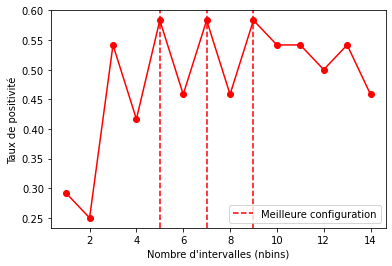

In [16]:
plot_hyperparameter_tuning(res,x_axis_title="Nombre d'intervalles (nbins)")

Il y a 3 valeurs qui nous donne une performance maximale: 5, 7 et 9.\
On va ensuite faire varier la taille de la cellule mais cett fois-ci on va regarder cette variation pour chacune des trois valeurs précédemment relevé pour le nombre d'intervalle.\
On regardera les couples de valeurs qui nous donne les performances les plus hautes.\
Par soucie d'effficacité, dans un premier temps, on regarde la taille des cellule de $1\times1$ à $13\times13$ avec un pas de $2\times2$.

In [17]:

res={}
blockSizeInCells = (2,2) #Taille des bloc en nombre de cellules
nbins = 9
for i in range(1,14,2):
    for j in [5,7,9]:
        cellSize = (i,i)
        #On converti la taille des blocs en pixels
        blockSize=(blockSizeInCells[1]*cellSize[1],blockSizeInCells[0]*cellSize[0])
        #On s'assure que la taille de la fenêtre soit un multiple du nombre de cellule
        winSize=((sizeX//cellSize[1])*cellSize[1],(sizeY//cellSize[0])*cellSize[0])
        #On donne comme pas entre chaque bloc l'équivelent d'une cellule
        blockStride = cellSize
        nbins=j

        #On définie la configuration de notre méthode HOG et on évalue ses performances
        hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)
        positive_rate=get_positive_rate(img_labels,img_labels ,method="HOG",mth_config=hog)
        res["cell's size:"+str(cellSize)+" nbins:"+str(j)]=positive_rate



On obtient le taux de positivité maximal: 0.6666666666666666pour les valeurs d'hyperparamètre suivantes:
["cell's size:(11, 11) nbins:9", "cell's size:(13, 13) nbins:9"]


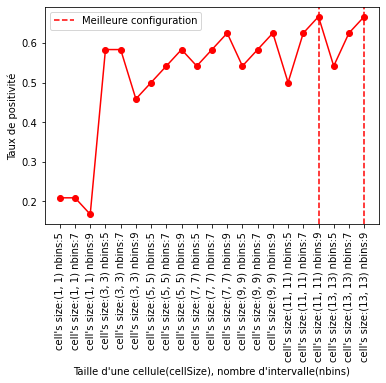

In [18]:
plot_hyperparameter_tuning(res,x_label_orientation="vertical",x_axis_title="Taille d'une cellule(cellSize), nombre d'intervalle(nbins)")

On semble obtenir de meilleurs résultats pour les couples où la valeur de  a taille des cellules est supérieur à $9\times9$.
Cette fois-ci on regarde donc la variation de la taille des cellule de $9\times9$ à $13\times13$ avec un pas de $1\times1$
(toujours pour chaque valeur 5,6 et 7 pour le nombre d'intervalle).

In [19]:
res={}
blockSizeInCells = (2,2)
nbins = 9

for i in range(9,14,1):
    for j in [5,7,9]:
        cellSize = (i,i)
        blockSize=(blockSizeInCells[1]*cellSize[1],blockSizeInCells[0]*cellSize[0])
        winSize=((sizeX//cellSize[1])*cellSize[1],(sizeY//cellSize[0])*cellSize[0])
        blockStride = cellSize
        nbins=j
        hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)
        positive_rate=get_positive_rate(img_labels,img_labels ,method="HOG",mth_config=hog)
        res["cell's size:"+str(cellSize)+" nbins:"+str(j)]=positive_rate



On obtient le taux de positivité maximal: 0.6666666666666666pour les valeurs d'hyperparamètre suivantes:
["cell's size:(10, 10) nbins:9", "cell's size:(11, 11) nbins:9", "cell's size:(12, 12) nbins:9", "cell's size:(13, 13) nbins:9"]


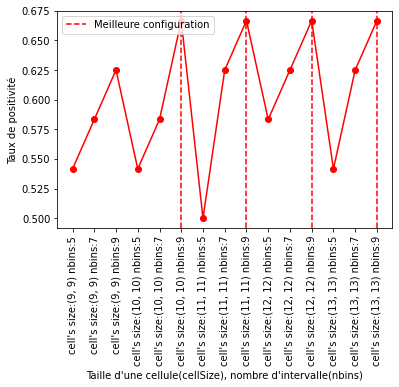

In [20]:
plot_hyperparameter_tuning(res,x_label_orientation="vertical",x_axis_title="Taille d'une cellule(cellSize), nombre d'intervalle(nbins)")

In [21]:
res={}
blockSizeInCells = (2,2)
nbins = 9
for i in range(1,14,1):
    cellSize = (i,i)
    blockSize=(blockSizeInCells[1]*cellSize[1],blockSizeInCells[0]*cellSize[0])
    winSize=((sizeX//cellSize[1])*cellSize[1],(sizeY//cellSize[0])*cellSize[0])
    blockStride = cellSize
    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)
    positive_rate=get_positive_rate(img_labels,img_labels ,method="HOG",mth_config=hog)
    res[str(cellSize)]=positive_rate


On obtient le taux de positivité maximal: 0.6666666666666666pour les valeurs d'hyperparamètre suivantes:
['(10, 10)', '(11, 11)', '(12, 12)', '(13, 13)']


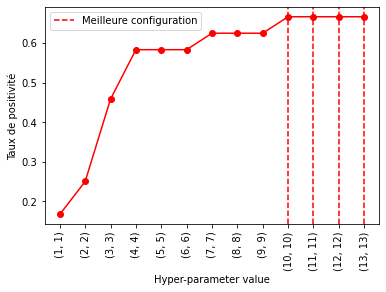

In [22]:
plot_hyperparameter_tuning(res,x_label_orientation="vertical")

Il semblerait donc que le couple contenant 9 comme nombre d'intervalle donne une performance plus importante.\
On fixe donc nbins=9.\
Mais 4 valeurs pour la taille donne la même performance avec ce nombre d'intervalle: $10\times10$, $11\times11$, $12\times12$, $13\times13$.\
On regarde donc, pour chaqu'une de ces 4 valeurs, les variations de l'hyper-paramètre suivant, à savoir la taille des blocs.


In [23]:
res={}
blockSizeInCells = (2,2)
nbins = 9
for i in range(10,14):
    for j in [4,5,7,8]:
        cellSize = (i,i)
        blockSizeInCells = (j,j)
        blockSize=(blockSizeInCells[1]*cellSize[1],blockSizeInCells[0]*cellSize[0])
        winSize=((sizeX//cellSize[1])*cellSize[1],(sizeY//cellSize[0])*cellSize[0])
        blockStride = cellSize
        hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)
        positive_rate=get_positive_rate(img_labels,img_labels ,method="HOG",mth_config=hog)
        res["cell's size:"+str(cellSize)+" blockSize:"+str(blockSizeInCells)]=positive_rate



On obtient le taux de positivité maximal: 0.7083333333333334pour les valeurs d'hyperparamètre suivantes:
["cell's size:(11, 11) blockSize:(4, 4)", "cell's size:(11, 11) blockSize:(5, 5)", "cell's size:(11, 11) blockSize:(7, 7)", "cell's size:(11, 11) blockSize:(8, 8)", "cell's size:(12, 12) blockSize:(4, 4)", "cell's size:(12, 12) blockSize:(5, 5)", "cell's size:(12, 12) blockSize:(7, 7)", "cell's size:(13, 13) blockSize:(4, 4)"]


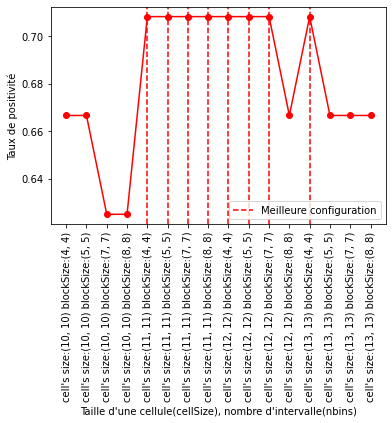

In [24]:
plot_hyperparameter_tuning(res,x_label_orientation="vertical",x_axis_title="Taille d'une cellule(cellSize), nombre d'intervalle(nbins)")

On remarque que beaucoup de couple de valeur semble donner des bonnes performances. Cependant, au sein de ces couples, $11\times11$ semble revenir le plus souvent comme taille de cellule. On fixe donc la taille de cellule à  $11\times11$. 
On regarde ensuite la taille des blocs:

In [25]:
res={}
cellSize = (11,11)
nbins = 9
blockStride = cellSize
winSize=((sizeX//cellSize[1])*cellSize[1],(sizeY//cellSize[0])*cellSize[0])
for i in range(1,10,1):
    blockSizeInCells = (i,i)
    blockSize=(blockSizeInCells[1]*cellSize[1],blockSizeInCells[0]*cellSize[0])
    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)
    positive_rate=get_positive_rate(img_labels,img_labels ,method="HOG",mth_config=hog)
    res[str(blockSizeInCells)]=positive_rate


On obtient le taux de positivité maximal: 0.7083333333333334pour les valeurs d'hyperparamètre suivantes:
['(4, 4)', '(5, 5)', '(7, 7)', '(8, 8)']


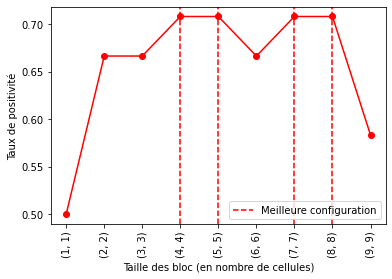

In [26]:
plot_hyperparameter_tuning(res,x_label_orientation="vertical",x_axis_title="Taille des bloc (en nombre de cellules)")

Il y a quatre choix possible et équivalent. Nous avons choisi de selectionner pour la taille de bloc une taille de $7\times7$ cellules.

On a donc fixé les hyper-paramètre suivants:
- taille des bloc=$7\times7$ cellules
- taille des cellules= $11\times11$ pixels 
- nombre d'intervalle (nbins)= 9
- pas entre chaque bloc supperposé=taille des cellules= $11\times11$ pixels 

Face au cas de l'image query strawberry_query.jpg, nous avons prévu de nous baser sur un seuil pour rejeter des images dont la distances avec l'images requête serait jugé trop importante pour être considéré comme similaire.
Nous avons cherché à optimiser ce seuil (plus de détail dans le rapport), regardons les résultats suivants:

On obtient le taux de positivité maximal: 0.6296296296296295pour les valeurs d'hyperparamètre suivantes:
['55', '60', '65', '70', '75']


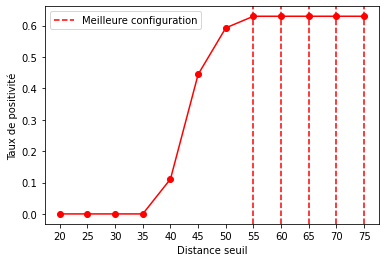

In [14]:
res={}
blockSizeInCells = (7,7)
cellSize = (11,11)
nbins = 9
blockSize=(blockSizeInCells[1]*cellSize[1],blockSizeInCells[0]*cellSize[0])
blockStride = cellSize
winSize=((sizeX//cellSize[1])*cellSize[1],(sizeY//cellSize[0])*cellSize[0])

#Cette fois-ci on tient compte de l'image requête associée à la fraise
query_labels=["airplane","ball","car","cat","dolphin","face","lotus", "pickles","strawberry"]
img_labels=["airplane","ball","car","cat","dolphin","face","lotus", "pickles"]

for i in range(20,80,5):
    seuil=i
    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)
    positive_rate=get_positive_rate2(query_labels,img_labels,seuil,method="HOG",mth_config=hog)
    res[str(seuil)]=positive_rate
plot_hyperparameter_tuning(res,x_axis_title="Distance seuil")

In [28]:
res={}
blockSizeInCells = (7,7)
cellSize = (11,11)
nbins = 9
blockSize=(blockSizeInCells[1]*cellSize[1],blockSizeInCells[0]*cellSize[0])
blockStride = cellSize
winSize=((sizeX//cellSize[1])*cellSize[1],(sizeY//cellSize[0])*cellSize[0])

query_labels=["airplane","ball","car","cat","dolphin","face","lotus", "pickles","strawberry"]
img_labels=["airplane","ball","car","cat","dolphin","face","lotus", "pickles"]
for i in range(20,60,3):
    seuil=i
    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)
    positive_rate=get_positive_rate2(query_labels,img_labels,seuil ,method="HOG",mth_config=hog)
    res[str(seuil)]=positive_rate


On obtient le taux de positivité maximal: 0.6296296296296295pour les valeurs d'hyperparamètre suivantes:
['53', '56', '59']


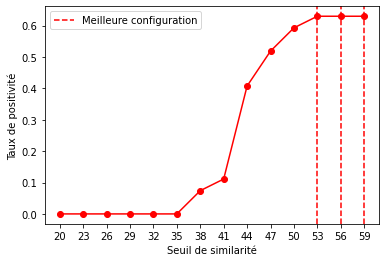

In [29]:
plot_hyperparameter_tuning(res,x_axis_title="Seuil de similarité")

In [12]:
res={}
blockSizeInCells = (7,7)
cellSize = (11,11)
nbins = 9
blockSize=(blockSizeInCells[1]*cellSize[1],blockSizeInCells[0]*cellSize[0])
blockStride = cellSize
winSize=((sizeX//cellSize[1])*cellSize[1],(sizeY//cellSize[0])*cellSize[0])

query_labels=["airplane","ball","car","cat","dolphin","face","lotus", "pickles","strawberry"]
img_labels=["airplane","ball","car","cat","dolphin","face","lotus", "pickles"]
for i in range(40,55,1):
    seuil=i
    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)
    positive_rate=get_positive_rate2(query_labels,img_labels,seuil,method="HOG",mth_config=hog)
    res[str(seuil)]=positive_rate


On obtient le taux de positivité maximal: 0.6296296296296295pour les valeurs d'hyperparamètre suivantes:
['52', '53', '54']


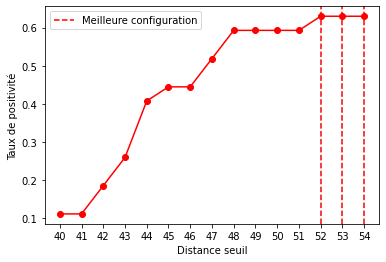

In [13]:
plot_hyperparameter_tuning(res,x_axis_title="Distance seuil")

On voit bien que la courbe converge vers une valeur maximal:Cela suggère qu'un seuil plus grand que toute les distances possible entre nos images donnerait une meilleur performance. De toute évidence, cela amène au fait de ne pas utiliser de seuil tout court...
Nous aurons donc nécessairement des erreurs en utilisant la fraise en image requête mais cela n'aura pas d'impact considérable sur le performacne global. Au contraire, se soucier de ces erreurs en particuliers réduirait la performance.

#### Résultat pour l'hypothèse 1 et 2 <a class="anchor" id="methode-hog-hyp1-2"></a>

On commence par fixer nos hyper-paramètres selon l'optimisation qui a été réalisé plus haut.

In [121]:
blockSizeInCells = (7,7) #Taille des blocs en nombre de cellules
cellSize = (11,11) #Taille d'une cellule en pixel
nbins = 9 #Nombre d'intervalle pour constituer l'histogramme
blockSize=(blockSizeInCells[1]*cellSize[1],blockSizeInCells[0]*cellSize[0]) #Taille des blocs en pixels
#On s'assure que la taille de la fenêtre soit un multiple du nombre de cellule
winSize=((sizeX//cellSize[1])*cellSize[1],(sizeY//cellSize[0])*cellSize[0])
blockStride = cellSize #On définit le pas entre chaque bloc comme équivalent à une cellule

#On instancie l'objet HOGDescriptor avec la bonne configuration
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)

In [122]:
#On s'assure de bien utiliser les images du database original
query_labels=["cat","lotus","dolphin","pickles","car","face","airplane","ball"]
img_labels=["cat","lotus","dolphin","pickles","car","face","airplane","ball"]
pathToImages="./"
img_data={}
img_query={}
for label in img_labels:
    img_query[label] = [str(p) for p in Path(pathToImages).glob(label+'*')]
    img_data[label] =  [str(p) for p in Path(pathToImages+"database").glob(label+'*')]
img_query

#On récupére les descripteurs HOG de toutes ces images
query_descriptors=get_queries_HOGdescriptors(hog,query_labels)
database_descriptors=get_database_HOGdescriptors(hog,img_labels)

Pour l'hypothèse 1, on se concentre sur les images requêtes de la balle, du lotus, du dauphin et du bocal.

In [123]:
query_labels=["ball","lotus","dolphin","pickles"]
#On récupère les descripteurs HOG des  images requêtes 
query_descriptors=get_queries_HOGdescriptors(hog,query_labels)
#On récupère les descripteurs HOG de toutes les images du database 
database_descriptors=get_database_HOGdescriptors(hog,img_labels)

On affiche le top3 pour toutes les images requêtes.

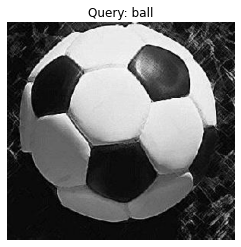

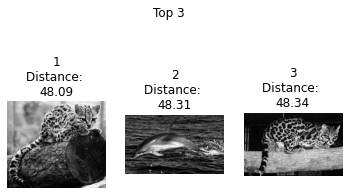

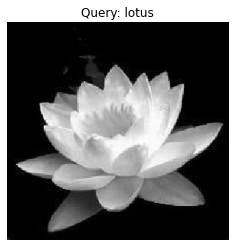

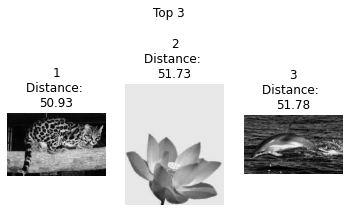

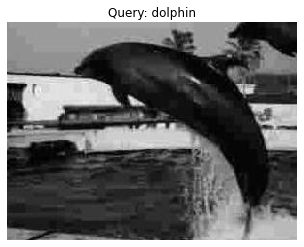

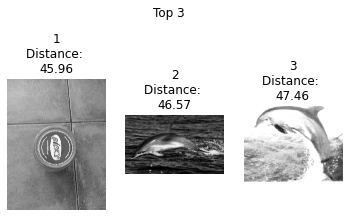

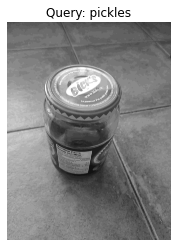

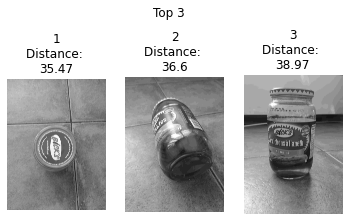

In [124]:
for label in query_labels:
        top3=get_top3(label,query_descriptors,database_descriptors, lambda a,b: np.linalg.norm(a-b),img_labels=img_labels)
        showtop3(top3)

On calcul le taux de bonne réponse:

In [125]:
get_positive_rate(query_labels,img_labels ,method="HOG",mth_config=hog)

0.5

Pour l'hypothèse 2, on se concentre sur les images requêtes de la voiture, du visage humain, et de l'avion.

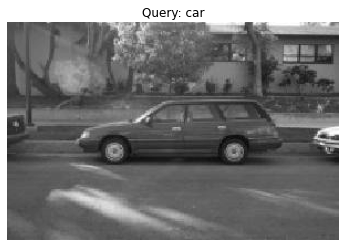

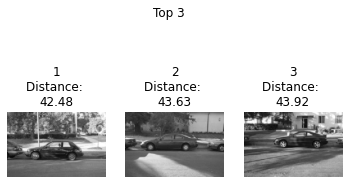

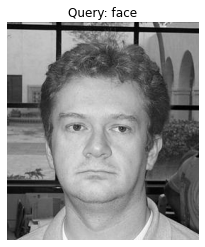

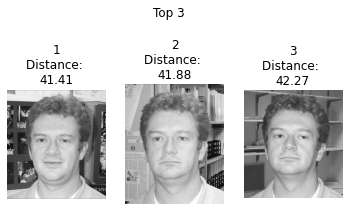

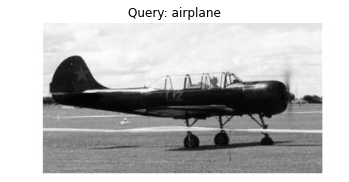

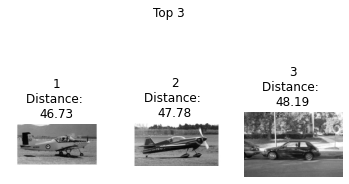

0.8888888888888888

In [126]:
query_labels=["car","face","airplane"]
#On récupère les descripteurs HOG des  images requêtes 
query_descriptors=get_queries_HOGdescriptors(hog,query_labels)
#On récupère les descripteurs HOG de toutes les images du database 
database_descriptors=get_database_HOGdescriptors(hog,img_labels)

#On affiche le top3 pour chaque image requête
for label in query_labels:
        top3=get_top3(label,query_descriptors,database_descriptors, lambda a,b: np.linalg.norm(a-b),img_labels=img_labels)
        showtop3(top3)

#On calcul le taux de bonne réponse
get_positive_rate(query_labels,img_labels,method="HOG",mth_config=hog)

#### Résultat pour l'hypothèse 3 <a class="anchor" id="methode-hog-hyp3"></a>

Pour l'hypothèse 3, on utilise toutes les images requêtes.
Cependant les images requêtes et celle du database sont issu d'un répertoire dans lequel se trouve des version rogner de ces dernière pour pouvoir réprésenter le résultat obtenu avec les boites englobantes.

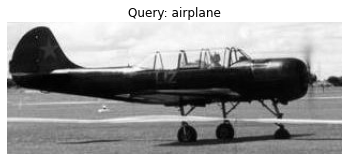

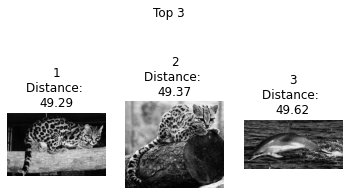

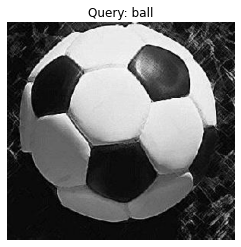

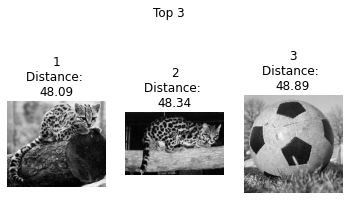

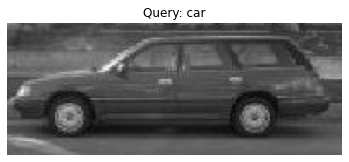

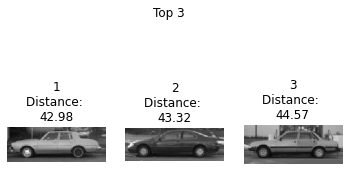

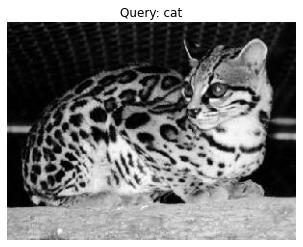

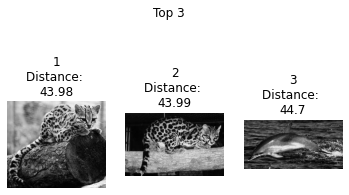

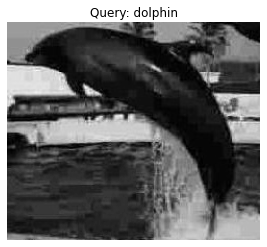

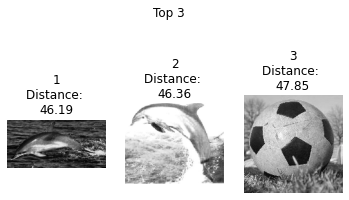

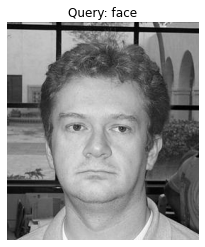

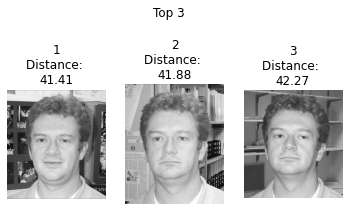

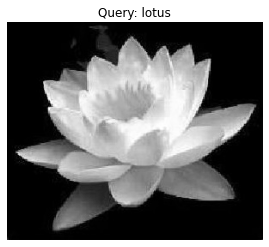

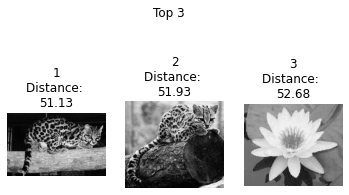

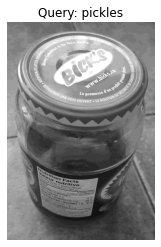

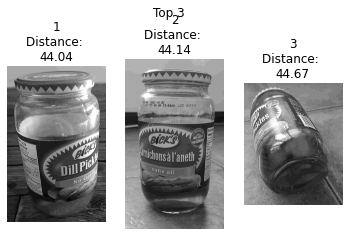

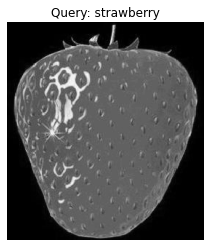

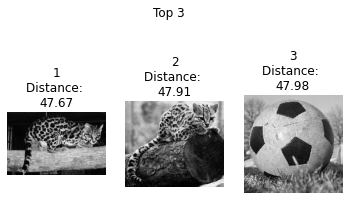

0.5555555555555556

In [127]:
query_labels=["airplane","ball","car","cat","dolphin","face","lotus", "pickles","strawberry"]
img_labels=["airplane","ball","car","cat","dolphin","face","lotus", "pickles"]

#Comme on utilise un nouveau set d'image, on récupère pour chaque label les images qui lui sont associé.
pathToImages="./data_boundingBox/"
img_data={}
img_query={}
for label in query_labels:
    img_query[label] = [str(p) for p in Path(pathToImages).glob(label+'*')]
for label in img_labels:
    img_data[label] =  [str(p) for p in Path(pathToImages+"database").glob(label+'*')]
img_query

#On récupère les descripteurs HOG de toutes es images
query_descriptors=get_queries_HOGdescriptors(hog,query_labels)
database_descriptors=get_database_HOGdescriptors(hog,img_labels)

#On affiche le top3 pour chaque image requête
for label in query_labels:
        top3=get_top3(label,query_descriptors,database_descriptors, lambda a,b: np.linalg.norm(a-b),img_labels=img_labels)
        showtop3(top3)

#On calcul le taux de bonne réponse
get_positive_rate(query_labels,img_labels ,method="HOG",mth_config=hog)

### Méthode SIFT <a class="anchor" id="methode-sift"></a>

#### Implémentation des méthodes <a class="anchor" id="methode-sift-implementation"></a>

In [23]:
#https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html
#correspond_SIFT1, fonction de détermination du score de correspondance entre une image query
#et une image de database. Elle calcul le nombre de points ou la distance euclédienne dépasse un certain seuil.
#les images les plus correspondante sont classée en ordre croissant
def correspond_SIFT1(descriptors_1,descriptors_2,keypoints_1,keypoints_2):
    bf = cv2.BFMatcher(cv2.NORM_L2) #NORM_L2 prend la distance euclidienne de donnée descripteurs
    matches = bf.knnMatch(descriptors_1,descriptors_2,k=2)#knnMatch nous permet d'avoir le meilleur match entre k points
    bonMatch = []
    # méthode du ratio on compare point à point leur ratio de distance et la compare à un seuil. 
    # On garde en mémoire les bons matchs
    # méthode du ratio: 
    for m,n in matches:
        if m.distance < 0.5*n.distance:
            bonMatch.append([m])
            break
    number_keypoints = 0
    if len(keypoints_1) <= len(keypoints_2):
        number_keypoints = len(keypoints_1)
    else:
        number_keypoints = len(keypoints_2)
    #on retourne un ratio de bon match par rapport au nombre de point clée minimal trouvé entre les 2 images
    indice = len(bonMatch)/number_keypoints * 100
    return indice

#correspond_SIFT2, fonction de détermination du score de correspondance entre une image query
#et une image de database. Elle calcul la moyenne de distance euclédienne des points ayant considéré correspondant par la 
#le paramètre crossCheck=True de la fonction cv2.BFMatcher
#les images les plus correspondante sont classée en ordre décroissant.
def correspond_SIFT2(descriptors_1,descriptors_2,keypoints_1,keypoints_2):
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)  #NORM_L2 prend la distance euclidienne de donnée descripteurs et trouve les points correspondant de crossCheck=True
    matches = bf.match(descriptors_1,descriptors_2)
    #calcul de la distance moyenne des points correspondant
    dist=0
    for match in matches:
        dist += match.distance
    return dist/len(matches)

# fonction de recherche dans la database pour SIFT
def search_database(query_label,sift= cv2.SIFT_create(nOctaveLayers = 3, contrastThreshold=0.03,edgeThreshold =15,sigma=4)):
    query=img_query[query_label][0]
    #lecture et détermination du descripteur SIFT de l'image query
    im_query = cv2.imread(query,cv2.IMREAD_GRAYSCALE)
    im_query =cv2.resize(im_query,(256,256))#On change la résolution de l'image
    #sift = cv2.SIFT_create(nOctaveLayers = 3, contrastThreshold=0.03,edgeThreshold =15,sigma=4)
    keypoints_1, descriptors_1 = sift.detectAndCompute(im_query,None)
    result = {}
    #comparaison avec chaque image de la database par rapport au score retourné d'une fonction de correspondance
    for label in img_labels:
        for images in img_data[label]:
            database = cv2.imread(images,cv2.IMREAD_GRAYSCALE)
            database = cv2.resize(database,(256,256))

            keypoints_2, descriptors_2 = sift.detectAndCompute(database,None)
            #find matches with brute force matching:
            score = correspond_SIFT2(descriptors_1,descriptors_2,keypoints_1,keypoints_2)
            result[score] = [images,label,score]
    #triage des éléments de la database en ordre croissant par rapport au score
    myKeys = list(result.keys())
    myKeys.sort()
    sorted_dict = {i: result[i] for i in myKeys}
    return sorted_dict


#### Recherche d'hyperparamètre  <a class="anchor" id="methode-sift-hyperparametre"></a>

On procède de la même manière que pour HOG pour déterminer la valeur des hyper-paramètres


In [24]:
#On s'assure que l'on utilise bien la banque d'image sans les boites englobantes en réinitialisant img_query et img_data.
query_labels=["airplane","ball","car","cat","dolphin","face","lotus", "pickles","strawberry"]
img_labels=["airplane","ball","car","cat","dolphin","face","lotus", "pickles"]
pathToImages="./"
    
img_data={}
img_query={}

for label in query_labels:
    img_query[label] = [str(p) for p in Path(pathToImages).glob(label+'*')]
for label in img_labels:
    img_data[label] =  [str(p) for p in Path(pathToImages+"database").glob(label+'*')]

On commence par s'intéresser en prémier lieu à l'impact du nombre d'octave sur la performance.

In [25]:
res={}
for i in range(1,10,1): 
    sift = cv2.SIFT_create(	nOctaveLayers = i, contrastThreshold=0.04,edgeThreshold = 10,sigma=1.6)
    positive_rate=get_positive_rate(img_labels,img_labels,img_labels,method="SIFT",mth_config=sift)
    res[str(i)]=positive_rate


On obtient le taux de positivité maximal: 0.5416666666666666pour les valeurs d'hyperparamètre suivantes:
['1']


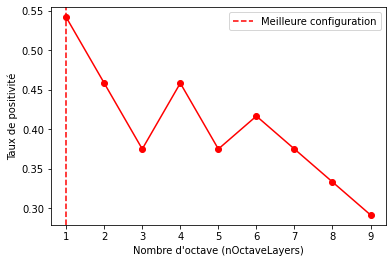

In [26]:
plot_hyperparameter_tuning(res,x_axis_title="Nombre d'octave (nOctaveLayers)")

De façon évident, avoir un seul octave donne un meilleur taux de bonnes réponses: plus d'explications concernant l'interprétation sont données dans le rapport.\
On fixe donc le nombre d'octave à 1 et on regarde ensuite l'influence du seuil de contraste.

In [27]:
res={}
for i in range(1,10,1):
    
    sift = cv2.SIFT_create(	nOctaveLayers = 1, contrastThreshold=0.01*i,edgeThreshold = 10,sigma=1.6)
    positive_rate=get_positive_rate(img_labels,img_labels,img_labels,method="SIFT",mth_config=sift)
    res[str(0.01*i)]=positive_rate


On obtient le taux de positivité maximal: 0.7083333333333334pour les valeurs d'hyperparamètre suivantes:
['0.05']


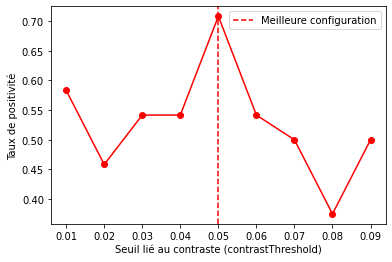

In [28]:
plot_hyperparameter_tuning(res, x_axis_title="Seuil lié au contraste (contrastThreshold)")

Un seul fixé à 0.05 donne la meilleur performance. On fixe donc contrastThreshold à 0.05.\
On s'intéresse maintenant à la variation du seuil qui concerne les contours.

In [29]:
res={}
for i in range(2,20,2):
    
    sift = cv2.SIFT_create(	nOctaveLayers = 1, contrastThreshold=0.05,edgeThreshold = i,sigma=1.6)
    positive_rate=get_positive_rate(img_labels,img_labels,method="SIFT",mth_config=sift)
    res[str(i)]=positive_rate

On obtient le taux de positivité maximal: 0.7083333333333334pour les valeurs d'hyperparamètre suivantes:
['10']


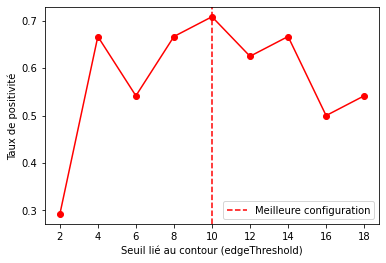

In [30]:
plot_hyperparameter_tuning(res, x_axis_title="Seuil lié au contour (edgeThreshold)")

Au vu des résultat précédent, on fixe notre seuil à 10 (edgeThreshold = 10).\
Pour finir, on regarde l'influence de la veleur du sigma des gaussiennes:

In [31]:
res={}
for i in [0.5,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2,5,10]:
    sift = cv2.SIFT_create(	nOctaveLayers = 1, contrastThreshold=0.05,edgeThreshold = 10,sigma=i)
    positive_rate=get_positive_rate(img_labels,img_labels,method="SIFT",mth_config=sift)
    res[str(i)]=positive_rate

On obtient le taux de positivité maximal: 0.7083333333333334pour les valeurs d'hyperparamètre suivantes:
['1.6']


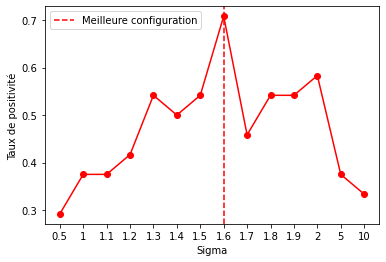

In [32]:
plot_hyperparameter_tuning(res,x_axis_title="Sigma")

On fixe donc sigma=1.6.\
Nous avons donc défini nos 4 hyperparamètres liés à la méthode SIFT.
Mais il faut à présent déterminer le seuil qui concerne la distance entre l'image requête et une autre image au delà duquel on considère que cette dernière n'est pas similaire à l'image requête.

On obtient le taux de positivité maximal: 0.6296296296296297pour les valeurs d'hyperparamètre suivantes:
['320', '340', '360', '380']


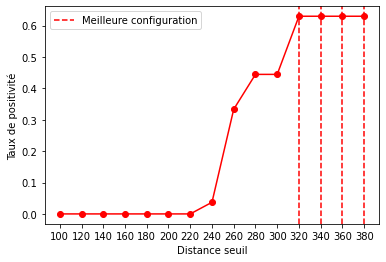

In [33]:
query_labels=["airplane","ball","car","cat","dolphin","face","lotus", "pickles","strawberry"]
img_labels=["airplane","ball","car","cat","dolphin","face","lotus", "pickles"]
res={}
for i in range(100,400,20):
    seuil=i
    sift = cv2.SIFT_create(	nOctaveLayers = 1, contrastThreshold=0.05,edgeThreshold = 10,sigma=1.6)
    positive_rate=get_positive_rate2(query_labels,img_labels,seuil ,method="SIFT",mth_config=sift)
    res[str(seuil)]=positive_rate
plot_hyperparameter_tuning(res, x_axis_title="Distance seuil")

In [34]:
query_labels=["airplane","ball","car","cat","dolphin","face","lotus", "pickles","strawberry"]
img_labels=["airplane","ball","car","cat","dolphin","face","lotus", "pickles"]
res={}
for i in range(200,300,10):
    seuil=i
    sift = cv2.SIFT_create(	nOctaveLayers = 1, contrastThreshold=0.05,edgeThreshold = 10,sigma=1.6)
    positive_rate=get_positive_rate2(query_labels,img_labels,seuil ,method="SIFT",mth_config=sift)
    res[str(seuil)]=positive_rate

On obtient le taux de positivité maximal: 0.4444444444444444pour les valeurs d'hyperparamètre suivantes:
['280', '290']


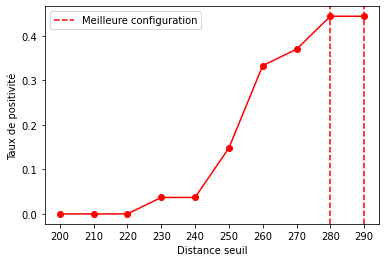

In [35]:
plot_hyperparameter_tuning(res,x_axis_title="Distance seuil")

De là même façon qu'avec HOG, on voit bien que notre courbe converge vers une valeur maximal:Cela suggère qu'un seuil plus grand que toute les distances possible entre nos images donnerait une meilleur performance. De toute évidence, cela amène au fait de ne pas utiliser de seuil tout court...
Nous aurons donc nécessairement des erreurs en utilisant la fraise en image requête mais cela n'aura pas d'impact considérable sur le performacne global. Au contraire, se soucier de ces erreurs en particuliers réduirait la performance.

#### Résultat pour l'hypothèse 1 <a class="anchor" id="methode-sift-hyp1"></a>

On affiche les résultat obtenues avec le jeu de données de l'hypothèse 1 (images du ballon, du lotus, du dauphin, et du bocal)

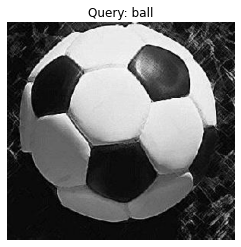

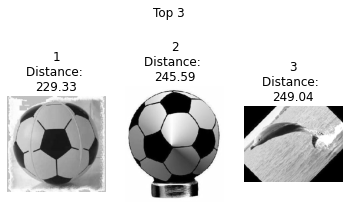

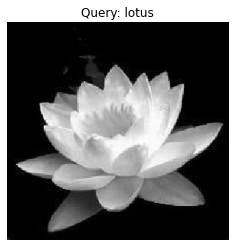

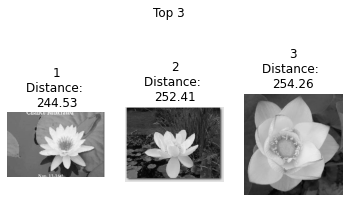

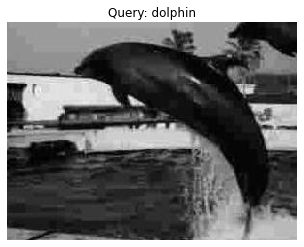

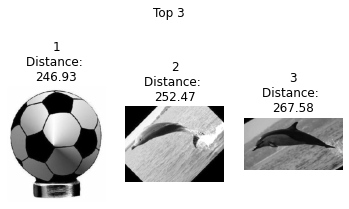

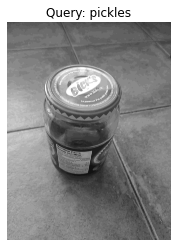

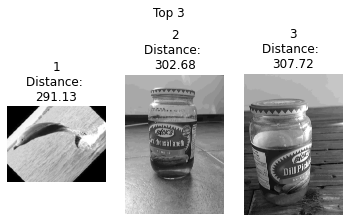

0.7499999999999999

In [36]:
query_labels=["ball","lotus","dolphin","pickles"]
sift = cv2.SIFT_create(	nOctaveLayers = 1, contrastThreshold=0.05,edgeThreshold = 10,sigma=1.6)
for label in query_labels:
    res=search_database(label,sift)
    top3={}
    top3["query_label"]=label
    top3["result"]=[res[i] for i in iter(res)][:3]
    showtop3(top3)

positive_rate=get_positive_rate(query_labels,img_labels,method="SIFT",mth_config=sift)
positive_rate

#### Résultat pour l'hypothèse 2 <a class="anchor" id="methode-sift-hyp2"></a>

On affiche les résultat obtenues avec le jeu de données de l'hypothèse 2 (images de la voiture, du visage, et de l'avion)

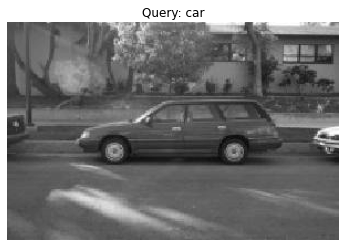

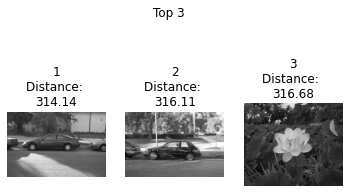

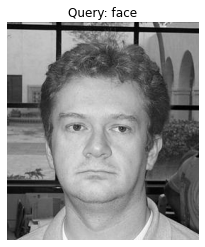

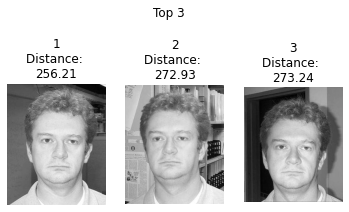

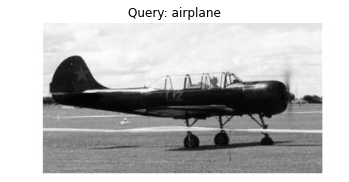

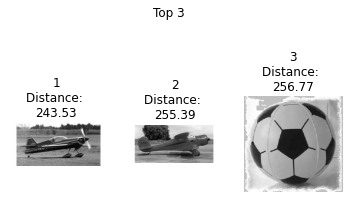

0.7777777777777777

In [37]:
query_labels=["car","face","airplane"]
sift = cv2.SIFT_create(	nOctaveLayers = 1, contrastThreshold=0.05,edgeThreshold = 10,sigma=1.6)
for label in query_labels:
    res=search_database(label,sift)
    top3={}
    top3["query_label"]=label
    top3["result"]=[res[i] for i in iter(res)][:3]
    showtop3(top3)

positive_rate=get_positive_rate(query_labels,img_labels,method="SIFT",mth_config=sift)
positive_rate

#### Résultat pour l'hypothèse 3 <a class="anchor" id="methode-sift-hyp3"></a>

Pour l'hypothèse 3, on utilise toutes les images requêtes.
Cependant les images requêtes et celle du database sont issu d'un répertoire dans lequel se trouve des version rognées de ces dernières ("./data_boundingBox/") pour pouvoir réprésenter le résultat obtenu avec les boites englobantes.

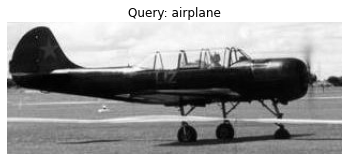

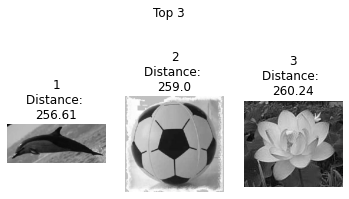

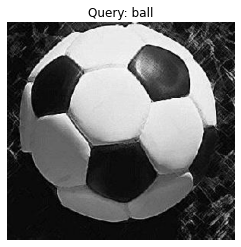

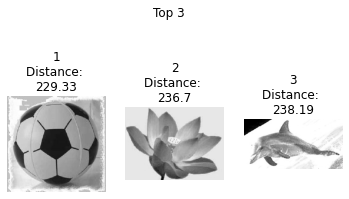

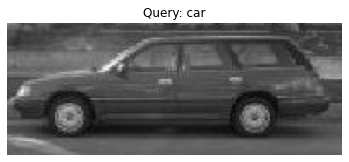

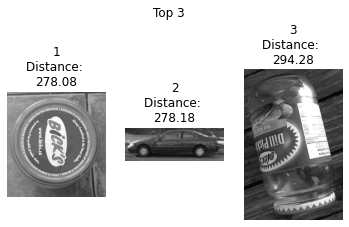

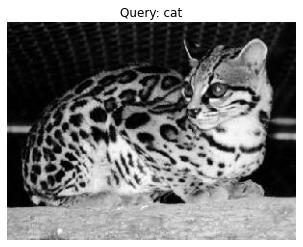

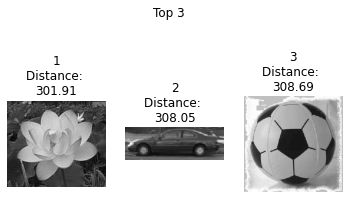

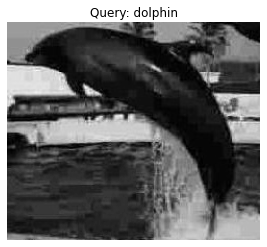

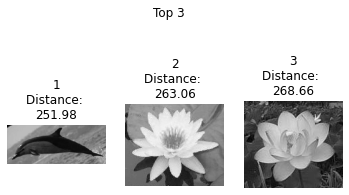

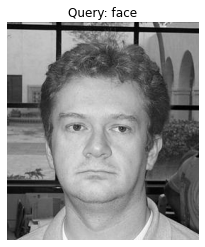

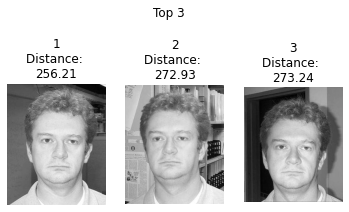

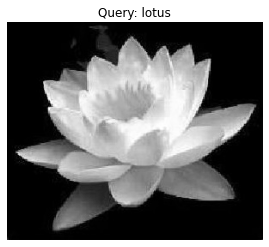

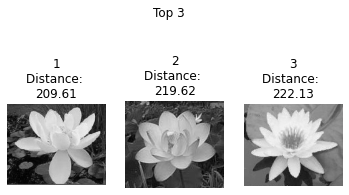

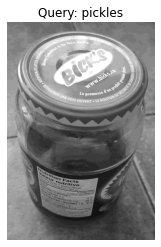

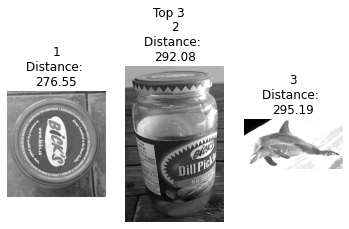

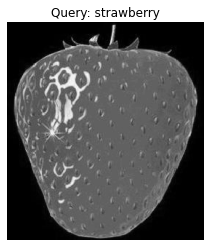

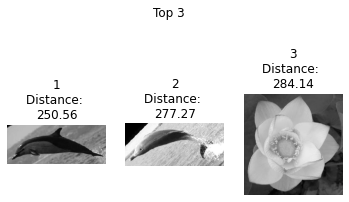

0.4074074074074074

In [38]:
#On prend bien soin de réinitialiser query_labels et img_labels avec les images correspondant aux boites englobantes.
query_labels=["airplane","ball","car","cat","dolphin","face","lotus", "pickles","strawberry"]
img_labels=["airplane","ball","car","cat","dolphin","face","lotus", "pickles"]
pathToImages="./data_boundingBox/"
img_data={}
img_query={}
for label in query_labels:
    img_query[label] = [str(p) for p in Path(pathToImages).glob(label+'*')]
for label in img_labels:
    img_data[label] =  [str(p) for p in Path(pathToImages+"database").glob(label+'*')]
query_descriptors=get_queries_HOGdescriptors(hog,query_labels)
database_descriptors=get_database_HOGdescriptors(hog,img_labels)

#On calcul et affiche les résultats
sift = cv2.SIFT_create(	nOctaveLayers = 1, contrastThreshold=0.05,edgeThreshold = 10,sigma=1.6)
for label in query_labels:
    res=search_database(label,sift)
    top3={}
    top3["query_label"]=label
    top3["result"]=[res[i] for i in iter(res)][:3]
    showtop3(top3)

positive_rate=get_positive_rate(query_labels,img_labels,method="SIFT",mth_config=sift)
positive_rate

### Temps d'exécution des méthodes <a class="anchor" id="temps-execution"></a>

On cherche dans cette section à observer le temps d'exécution des méthodes HOG et SIFT.\
On distingue le temps mis pour obtenir les descripteurs (cf tableau HOG_dt et SIFT_dt) du temps mis pour obtenir les mesures de similarité entre les descripteurs (cf tableau HOG_dist_dt et SIFT_dist_dt).

In [39]:
#On s'assure que l'on utilise bien la banque d'image sans les boites englobantes en réinitialisant img_query et img_data.
img_labels=["airplane","ball","car","cat","dolphin","face","lotus", "pickles"]
pathToImages="./"
    
img_data={}
img_query={}
for label in img_labels:
    img_query[label] = [str(p) for p in Path(pathToImages).glob(label+'*')]
    img_data[label] =  [str(p) for p in Path(pathToImages+"database").glob(label+'*')]
img_query

{'airplane': ['airplane_query.jpg'],
 'ball': ['ball_query.jpg'],
 'car': ['car_query.jpg'],
 'cat': ['cat_query.jpg'],
 'dolphin': ['dolphin_query.jpg'],
 'face': ['face_query.jpg'],
 'lotus': ['lotus_query.jpg'],
 'pickles': ['pickles_querry.jpg']}

In [40]:
import time


blockSizeInCells = (7,7) #Taille des blocs en nombre de cellules
cellSize = (11,11) #Taille d'une cellule en pixel
nbins = 9 #Nombre d'intervalle pour constituer l'histogramme
blockSize=(blockSizeInCells[1]*cellSize[1],blockSizeInCells[0]*cellSize[0]) #Taille des blocs en pixels
#On s'assure que la taille de la fenêtre soit un multiple du nombre de cellule
winSize=((sizeX//cellSize[1])*cellSize[1],(sizeY//cellSize[0])*cellSize[0])
blockStride = cellSize #On définit le pas entre chaque bloc comme équivalent à une cellule
#On instancie l'objet HOGDescriptor avec la bonne configuration
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)


#On instancie l'objet SIFT avec la bonne configuration
sift = cv2.SIFT_create(	nOctaveLayers = 1, contrastThreshold=0.05,edgeThreshold = 10,sigma=1.6)

#On regardera la similarité des descripteurs des images du database avec ceux de l'image requête pickles_querry.jpg
img=cv2.imread("./pickles_querry.jpg") 
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
resize_img=cv2.resize(gray,(sizeX,sizeY))
HOGDescriptor1=hog.compute(resize_img)
keypoints1, descriptors1 = sift.detectAndCompute(resize_img,None)

SIFT_dist_d_t=[] #Contiendra les temps mis pour calculer le score de similarité choisi pour SIFT entre l'image du database et l'image requête
SIFT_d_t=[] #Contiendra les temps mis pour obtenir les points clé et les descripteurs des images du database avec SIFT
HOG_dist_d_t=[] #Contiendra les temps mis pour calculer le score de similarité choisi pour HOG entre l'image du database et l'image requête
HOG_d_t=[] #Contiendra les temps mis pour obtenir les descripteurs des images du database avec HOG

#On calcule la différence de temps pour obtenir les descripteurs et le score de similarité pour chaque image du database
for label in img_labels:
        for img_name in img_data[label]:
            img = cv2.imread(img_name)  
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resize_img=cv2.resize(gray,(sizeX,sizeY))

            #On cacule le temps pour obtenir le descripteur HOG de l'image
            HOG_start_t=time.time()
            HOGDescriptor2=hog.compute(resize_img)
            HOG_output_t=time.time()

            HOG_d_t.append(HOG_output_t-HOG_start_t)

            #On cacule le temps pour obtenir la distance entre les descripteur HOG de l'image requête et de l'image du database
            HOG_dist_start_t=time.time()
            dist_HOG = np.linalg.norm(HOGDescriptor1-HOGDescriptor2)
            HOG_dist_output_t=time.time()

            HOG_dist_d_t.append(HOG_dist_output_t-HOG_dist_start_t)

            img = cv2.imread(img_name)  
            database = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            database=cv2.resize(database,(sizeX,sizeY))

            #On cacule le temps pour obtenir les points clés et les descripteurs SIFT de l'image
            SIFT_start_t=time.time()
            keypoints2, descriptors2 = sift.detectAndCompute(resize_img,None)
            SIFT_output_t=time.time()

            SIFT_d_t.append(SIFT_output_t-SIFT_start_t)
            
            #On cacule le temps pour obtenir le score de similarité entre les descripteur SIFT de l'image requête et de l'image du database
            SIFT_dist_start_t=time.time()
            dist_SIFT = correspond_SIFT2(descriptors1,descriptors2,keypoints1,keypoints2)
            SIFT_dist_output_t=time.time()

            SIFT_dist_d_t.append(SIFT_dist_output_t-SIFT_dist_start_t)
            
print("Temps d'execution moyen pour obtenir lesdescripteurs HOG d'une image: "+str(np.mean(HOG_d_t)))
print("Temps d'execution moyen pour obtenir points clés et descripteurs SIFT d'une image: "+str(np.mean(SIFT_d_t)))
print("Temps d'execution moyen pour obtenir le score de similarité \n d'une image du database avec l'image requête pour HOG: "+str(np.mean(HOG_dist_d_t)))
print("Temps d'execution moyen pour obtenir le score de similarité \n d'une image du database avec l'image requête pour SIFT: "+str(np.mean(SIFT_dist_d_t)))
        

Temps d'execution moyen pour obtenir lesdescripteurs HOG d'une image: 0.12272536754608154
Temps d'execution moyen pour obtenir points clés et descripteurs SIFT d'une image: 0.12748025059700013
Temps d'execution moyen pour obtenir le score de similarité 
 d'une image du database avec l'image requête pour HOG: 0.002747935056686401
Temps d'execution moyen pour obtenir le score de similarité 
 d'une image du database avec l'image requête pour SIFT: 0.0036118626594543457


Portons un regard sur les statistiques que l'on peut en tirer:

In [41]:
import pandas as pd

HOG_stat = pd.DataFrame(np.array(HOG_d_t))
HOG_stat.describe()


,0
count,40.000000
mean,0.122725
std,0.008207
min,0.104491
25%,0.117430
50%,0.121746
75%,0.127280
max,0.145603


In [42]:
SIFT_stat = pd.DataFrame(np.array(SIFT_d_t))
SIFT_stat.describe()

,0
count,40.000000
mean,0.127480
std,0.024853
min,0.101183
25%,0.118837
50%,0.123087
75%,0.131140
max,0.268137


In [43]:
HOG_dist_stat = pd.DataFrame(np.array(HOG_dist_d_t))
HOG_dist_stat.describe()

,0
count,40.000000
mean,0.002748
std,0.000964
min,0.001665
25%,0.002000
50%,0.002347
75%,0.003009
max,0.005253


In [44]:
SIFT_dist_stat = pd.DataFrame(np.array(SIFT_dist_d_t))
SIFT_dist_stat.describe()

,0
count,40.000000
mean,0.003612
std,0.002479
min,0.000972
25%,0.001961
50%,0.003015
75%,0.004612
max,0.012491


Les temps d'exécution pour HOG et SIFT semble relativemnt proche. EN théorie SIFT est beaucoup plus lent. Mais dans notre configuration, la méthode SIFT n'utilise qu'un octave. En augmentant le nombre d'octave le temps d'exécution de SIFT devrait être plus important.
Nous allons vérifier cela en regardant le temps moyen pour un nombre d'octave de 1 à 9: 

In [45]:
query_labels=["airplane","ball","car","cat","dolphin","face","lotus", "pickles","strawberry"]
img_labels=["airplane","ball","car","cat","dolphin","face","lotus", "pickles"]
res_SIFT_d_t={}
res_SIFT_dist_d_t={}
for i in range(1,10,1):
    sift = cv2.SIFT_create(	nOctaveLayers = i, contrastThreshold=0.05,edgeThreshold = 10,sigma=1.6)
    SIFT_dist_d_t=[] #Contiendra les temps mis pour calculer le score de similarité choisi pour SIFT entre l'image du database et l'image requête
    SIFT_d_t=[] #Contiendra les temps mis pour obtenir les points clé et les descripteurs des images du database avec SIFT
    HOG_dist_d_t=[] #Contiendra les temps mis pour calculer le score de similarité choisi pour HOG entre l'image du database et l'image requête
    HOG_d_t=[] #Contiendra les temps mis pour obtenir les descripteurs des images du database avec HOG

    #On calcule la différence de temps pour obtenir les descripteurs et le score de similarité pour chaque image du database
    for label in img_labels:
            for img_name in img_data[label]:

                img = cv2.imread(img_name)  
                database = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                database=cv2.resize(database,(sizeX,sizeY))

                #On cacule le temps pour obtenir les points clés et les descripteurs SIFT de l'image
                SIFT_start_t=time.time()
                keypoints2, descriptors2 = sift.detectAndCompute(resize_img,None)
                SIFT_output_t=time.time()

                SIFT_d_t.append(SIFT_output_t-SIFT_start_t)
                
                #On cacule le temps pour obtenir le score de similarité entre les descripteur SIFT de l'image requête et de l'image du database
                SIFT_dist_start_t=time.time()
                dist_SIFT = correspond_SIFT2(descriptors1,descriptors2,keypoints1,keypoints2)
                SIFT_dist_output_t=time.time()

                SIFT_dist_d_t.append(SIFT_dist_output_t-SIFT_dist_start_t)
    res_SIFT_d_t[str(i)]=np.mean(SIFT_d_t)
    res_SIFT_dist_d_t[str(i)]=np.mean(SIFT_dist_d_t)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


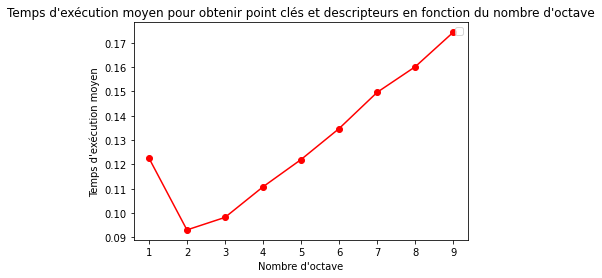

In [46]:
plt.plot(res_SIFT_d_t.keys(),res_SIFT_d_t.values(),'-ro')
plt.title("Temps d'exécution moyen pour obtenir point clés et descripteurs en fonction du nombre d'octave")
plt.ylabel("Temps d'exécution moyen")
plt.xlabel("Nombre d'octave")
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


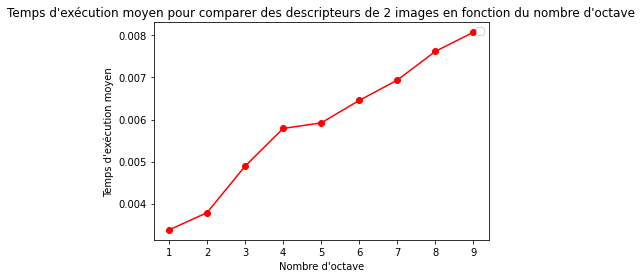

In [47]:
plt.plot(res_SIFT_dist_d_t.keys(),res_SIFT_dist_d_t.values(),'-ro')
plt.title("Temps d'exécution moyen pour comparer des descripteurs de 2 images en fonction du nombre d'octave")
plt.ylabel("Temps d'exécution moyen")
plt.xlabel("Nombre d'octave")
plt.legend()
plt.show()

De toute évidence, augmenter le nombre d'octave rend la méthode SIFT plus longue que HOG.